<a href="https://colab.research.google.com/github/eduardo-vicentini/artigoQN_data/blob/master/artigoQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curva de energia potencial para o FeC

## Pacotes necessários
As primeiras linhas do código importam os módulos e/ou funções específicas necessárias para as análises que serão feitas, que ficarão acessíveis ao programa durante toda a sua execução. Eles são utilizados para manipular os dados, utilizar os métodos já implementados de rede neural, calcular as derivadas e os mínimos das funções e construir gráficos.

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.misc import derivative
import matplotlib
import pandas as pd

## Valores para o treino
O primeiro passo é carregar, nas variáveis R e E, os valores de distância e energia, em ångström e hartree, respectivamente, calculados para a molécula pelo método de estrutura eletrônica. A estrutura de dados implementada pelo $\texttt{numpy}$ é utilizada para posterior aplicação nas redes neurais.

In [ ]:
R = np.array([1.00000000, 1.07142857, 1.14285714, 1.21428571, 1.28571429,
              1.35714286, 1.42857143, 1.50000000, 1.57142857, 1.64285714,
              1.71428571, 1.78571429, 1.85714286, 1.92857143, 2.00000000,
              2.07142857, 2.14285714, 2.21428571, 2.28571429, 2.35714286,
              2.42857143, 2.50000000, 2.57142857, 2.64285714, 2.71428571,
              2.78571429, 2.85714286, 2.92857143, 3.00000000, 3.07142857,
              3.14285714, 3.21428571, 3.28571429, 3.35714286, 3.42857143,
              3.50000000, 3.57142857, 3.64285714, 3.71428571, 3.78571429,
              3.85714286, 3.92857143, 4.00000000, 4.07142857, 4.14285714,
              4.21428571, 4.28571429, 4.35714286, 4.42857143, 4.50000000])

E = np.array([-1301.08782830, -1301.30527376, -1301.45192836, -1301.54998428,
              -1301.61355047, -1301.65233547, -1301.67362345, -1301.68346104,
              -1301.68684780,-1301.68685147, -1301.68481592, -1301.68128428,
              -1301.67655955, -1301.67090869,-1301.66457982, -1301.65780642,
              -1301.65077943, -1301.64366587, -1301.63659102, -1301.62965600,
              -1301.62294399, -1301.61651734, -1301.61042999, -1301.60473530,
              -1301.59948251, -1301.59472775, -1301.59051383, -1301.58682011,
              -1301.58359100, -1301.58075129, -1301.57824097, -1301.57601301,
              -1301.57402645, -1301.57225076, -1301.57065780, -1301.56922926,
              -1301.56794443, -1301.56679160, -1301.56575105, -1301.56481424,
              -1301.56397252, -1301.56321450, -1301.56250814, -1301.56192440,
              -1301.56137439, -1301.56086277, -1301.56044577, -1301.56005096,
              -1301.55968471, -1301.55935234])


Os dados, para serem utilizados no programa das redes neurais, precisam estar cada ponto dentro de uma lista, mesmo que essa seja de uma dimensão. Então, usa-se o $\texttt{reshape}$, que faz isso automaticamente.
Para aumentar a precisão do ajuste da rede neural, os valores de entrada são passados na forma da coordenada de Morse, que é uma descrição natural para a variação da energia com R. 

In [ ]:
# Transformação para coordenada de Morse
X = np.exp(-R) 
X = X.reshape(-1, 1)

## Expansão de muitos corpos
O próximo passo é tornar a energia relativa à dos átomos separados, o que aumenta a precisão do ajuste, ao se considerar uma expansão de muitos corpos:
        \begin{equation}
        V = V_{\mathrm{Fe}} + V_{\mathrm{O}} + V_{\mathrm{FeC}}(R_{\mathrm{FeC}})
        \end{equation}
pois uma parte do potencial é recuperada de forma exata e o restante fica por parte do ajuste, o que diminui o erro relativo.


In [ ]:
# Energia do Ferro atômico
E_Fe = -1263.697700554418
# Energia do carbono atômico
E_C = -37.859477787637

# Zerar a energia para os átomos dissociados
E = E - (E_Fe + E_C)


## Padronização dos valores
A próxima célula escala os valores para terem média zero e desvio padrão um. O fato de os dados estarem padronizados dessa forma ajuda na precisão da rede neural.

In [ ]:
X_escalado = (X - X.mean(axis=0))/X.std(axis=0)
E_escalado = (E - E.mean())/E.std()

## Ajuste da rede neural
Agora, vamos começar a ajustar a curva. 

É criada a função $\texttt{frmse}$ para calcular o erro quadrático médio dos pontos em relação à função ajustada.

O iterador, chamado pelo comando $\texttt{for}$, é utilizado para procurar um melhor parâmetro de inicialização do estado randômico, $\texttt{random_state}$. Isso é feito porque a otimização dos parâmetros da rede neural pode convergir para mínimos locais. 

A rede neural é criada no objeto $\texttt{mlp}$ que é uma instância da classe $\texttt{MLPRegressor}$. 
É durante a inicialização dessa classe que todos os parâmetros são selecionados.

O parâmetro $\texttt{activation}$ seleciona a função de ativação para as camadas escondidas, que dá o caráter não linear do ajuste.

O parâmetro $\texttt{solver}$ seleciona o método de otimização.

Os parâmetros $\texttt{tol}$ e $\texttt{max_iter}$ vão controlar, respectivamente, o limite de variação entre um ponto e outro para parar a minimização e o número máximo de iterações para chegar a esse limite.

O parâmetro $\texttt{hidden_layer_size}$ define quantas unidades e quantas camadas escondidas serão utilizadas. No caso, são utilizadas duas camadas escondidas, com a primeira com cinco neurônios e a segunda com dois neurônios.

O método $\texttt{fit}$ é utilizado para ajustar a rede neural ao conjunto de treino.
Após isso, é calculada a energia para cada ponto do ajuste pela rede neural que foi ajustada, 
utilizando o método $\texttt{predict}$ do objeto $\texttt{mlp}$.
Ele calcula, para a distância fornecida, o valor de energia na forma em que foi ajustado. 
Ou seja, é calculada a energia de forma escalada. 
Para conseguir a energia real, que possa ser comparada com o conjunto de treino, é necessário realizar a transformação inversa, que é multiplicar pelo desvio padrão e somar a média, já que a padronização para levar a média a zero e o desvio padrão a 1 é feita pela seguinte equação:

\begin{equation}
X_{\mathrm{escalado}} = \frac{X - \bar{X}}{X_{\sigma}}
\end{equation}
Em que $X$ é cada valor que será utilizado, $\bar{X}$ é a média deles e $X_{\sigma}$ é o desvio padrão desses valores.
Por fim, o bloco $\texttt{if}$ seleciona a melhor rede neural e salva os valores de energia calculados por ela e o erro quadrático médio.


In [ ]:
# Função raíz do erro quadrático médio
def frmse(X1, X2):
    erro = np.sqrt(sum((X1-X2)**2)/X1.size)
    return erro

# Estrutura de repetição para encontrar melhor random_state
melhor_rmse=100.0
for i in range(100):
        mlp = MLPRegressor(solver='lbfgs', random_state=i,
                       activation='tanh', tol=1e-16, max_iter=5000,
                       hidden_layer_sizes=[5, 2], alpha=10**-2)
        mlp.fit(X_escalado, E_escalado)
        e_calc = ((mlp.predict(X_escalado) * E.std() + E.mean()))
        rmse = 627.5094743*frmse(E, e_calc)
        if rmse < melhor_rmse:
            melhor_rmse = rmse
            melhor_mlp = mlp
            melhor_e = e_calc
            print("i = %d" %i)
            print("RMSE(kcal/mol) = %.8f" % rmse)

# Fim do loop


i = 0
RMSE(kcal/mol) = 0.63240778
i = 7
RMSE(kcal/mol) = 0.63131619
i = 17
RMSE(kcal/mol) = 0.62615868
i = 25
RMSE(kcal/mol) = 0.61271258
i = 30
RMSE(kcal/mol) = 0.60965387
i = 58
RMSE(kcal/mol) = 0.60491648


## Gráfico da curva de energia potencial do FeC
Agora, será feito um gráfico. 
A linha representará os valores de energia calculados pela rede neural para cada distância, gerados pelo método $\texttt{np.linspace}$. 
Os pontos são os valores calculados pelo método de estrutura eletrônica, utilizados no ajuste.
Para utilizar a rede neural, chamamos o método $\texttt{predict}$ do objeto $\texttt{melhor_mlp}$ e fazemos as transformações necessárias.

Por fim, as definições do gráfico são feitas para a inteface $\texttt{matplotlib.pyplot}$, que será usada para gerar o gráfico.

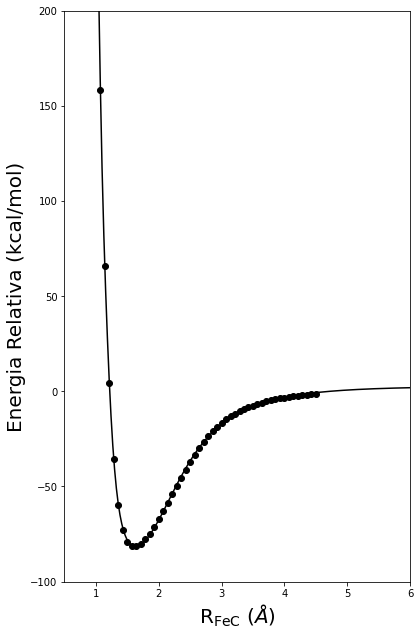

In [ ]:


# Código para fazer o gráfico da função ajustada
# Distâncias nas quais vamos calcular a energia, temos que repetir o processo
dist_plot = np.linspace(0.1, 50.0, 3500)
# Vamos fazer o tratamento com outra variável, para manter a anterior no gráfico
dist = np.exp(-dist_plot)
dist = (dist - X.mean(axis=0))/X.std(axis=0)
dist = dist.reshape(-1, 1)
# Energias pelo potencial ajustado
v_plot = (melhor_mlp.predict(dist)*E.std() + E.mean())


plt.figure(figsize=(6,9))
plt.plot(R, E*627.5049, 'o', color="black")
plt.plot(dist_plot, v_plot*627.5049, color="black")
plt.ylabel("Energia Relativa (kcal/mol)", size=20)
plt.xlabel("R$_\mathrm{FeC}$ ($\AA$)", size=20)

plt.ylim([-100.0, 200])
plt.xlim([0.5, 6])

matplotlib.rcParams.update({'font.size': 12})

plt.tight_layout()


plt.show()



## Cálculo das constantes espectroscópicas
Para calcular as constantes espectroscópicas, precisamos definir uma função da energia em relação à distância. Isso porque precisaremos definir sua derivada e procurar seu mínimo.
A função, ao receber uma distância nuclear, irá aplicar a transformação para a coordenada de Morse e irá escalar os valores com a metodologia já definida.

O $\texttt{reshape}$ é utilizado pelo mesmo motivo já explicado e, por fim, é utilizada a melhor rede neural para calcular o valor de energia.

In [ ]:
def v(X1):
    X1 = np.exp(-X1)
    X1_scaled = (X1 - X.mean(axis=0))/X.std(axis=0)

    X1_scaled = X1_scaled.reshape(1, -1)
    e_calc = (melhor_mlp.predict(X1_scaled)*E.std() + E.mean())

    return e_calc


Iremos calcular a distância de equilíbrio e a energia dessa geometria, pela função $\texttt{minimize}$.

O valor da frequência vibracional harmônica (em cm$^{-1}$) é obtido pela equação:

\begin{equation}
\omega_e = \frac{1}{2\pi c}\sqrt{\frac{k}{\mu}}
\end{equation}

Em que $k$ é a segunda derivada no mínimmo da função, $\mu$ é a massa reduzida da molécula e $c$ é a velocidade da luz no vácuo.
A segunda derivada é obtida pelo método $\texttt{derivative}$.

A energia de dissociação sem a energia do ponto zero é a diferença do mínimo para os átomos separados, que foram definidos como o zero da curva de energia potencial.



In [ ]:
r_tentativa = np.array([1.5])
opt = minimize(v, r_tentativa, tol=1e-12)

r_opt = opt.x[0]
d_e = -(opt.fun)*627.50947

# Massa reduzida em massa atômica em relação ao elétron
mu = 18010.685

# A função derivative recebe a função que vai ser derivada, o ponto, o grau da derivação
# e o limite de variação
k = 0.28002852*derivative(v, r_opt, n=2, dx=1e-6)

freq = 1/(2*np.pi*2.9979246e+10)*np.sqrt(k/mu)*4.1341373e+16

print("RMSE(kcal/mol) = %.8f" % melhor_rmse)
print("Distância de equilíbrio otimizada (angstrom) = %6.4f" % (r_opt))
print("Energia de dissociação (kcal/mol) = %6.3f" % d_e)
print("Constante vibracional harmônica (cm\u207B\N{SUPERSCRIPT ONE}) = %6.2f" % freq)


RMSE(kcal/mol) = 0.60491648
Distância de equilíbrio otimizada (angstrom) = 1.6299
Energia de dissociação (kcal/mol) = 81.526
Constante vibracional harmônica (cm⁻¹) = 609.36


# Ajuste para a reação H + H$_2$


## Criação das funções auxiliares

Para o ajuste, primeiro simetriza-se com os polinômios permutacionalmente invariantes (PIP), conseguindo um ajuste com menor quantidade de pontos.

Uma vez que se tem a camada de entrada e os dados para o treinamento, o ajuste é bem direto e parecido com o caso de uma dimensão.

Então, será calculado o erro para os pontos, serão feitos gráficos dos contornos da superfície de energia potencial eletrônica e comparados ao gráfico para o potencial utilizado no treinamento. 

Primeiro, são criadas algumas funções auxiliares. 
A função $\texttt{symm}$ irá receber três distâncias internucleares e retornar três coordenadas simetrizadas, utilizando os polinômios permutacionalmente invariantes para o caso de três átomos iguais.

In [ ]:
# Função de simetrização para sistema com 3 átomos iguais
def symm(x1, x2, x3):
    s1 = x1 + x2 + x3
    s2 = x1**2 + x2**2 + x3**2
    s3 = x1**3 + x2**3 + x3**3
    
    return s1,s2,s3

## Valores para o treino e padronização
A energia dada pelo potencial é relativa aos átomos separados e é lida no arquivo indicado na variável $\texttt{fname}$.

A próxima parte do código é para carregar nos vetores $\texttt{x}$ e $\texttt{e}$ as coordenadas simetrizadas e as energias do H + H$_2$ padronizadas, respectivamente. 

In [ ]:
url = 'https://raw.githubusercontent.com/eduardo-vicentini/artigoQN_data/master/h3_new.dat'

data = pd.read_csv(url, names=['r1', 'r2', 'r3', 'e'], sep="\s+")

r1 = data.r1.values
r2 = data.r2.values
r3 = data.r3.values
e = data.e.values

size = 1710



r = np.empty([size, 3])
for i in range(size):
             
    p1 = np.exp(-r1[i])
    p2 = np.exp(-r2[i])
    p3 = np.exp(-r3[i])
    
    g1, g2, g3 = symm(p1, p2, p3)

    
    g = np.array([g1, g2, g3])
    
    r[i, :] = g
    
x = np.copy(r)
x_escalado = (x - x.mean(axis=0))/x.std(axis=0)
e_escalado = (e - e.mean())/e.std()


## Ajuste da rede neural
Esse é um problema mais complexo. Então, construíremos menos redes neurais para diminuir o tempo de execução.

In [ ]:

# Estrutura de repetição para encontrar melhor random_state
melhor_rmse=100.0
for i in range(10):
        mlp = MLPRegressor(solver='lbfgs', random_state=i,
                       activation='tanh', tol=1e-16, max_iter=50000,
                       hidden_layer_sizes=[20, 10], alpha=10**-4)
        mlp.fit(x_escalado, e_escalado)
        e_calc = ((mlp.predict(x_escalado) * e.std() + e.mean()))
        rmse = 627.5094743*frmse(e, e_calc)
        if rmse < melhor_rmse:
            melhor_rmse = rmse
            melhor_mlp = mlp
            melhor_e = e_calc
            print("i = %d" %i)
            print("RMSE(kcal/mol) = %.8f" % rmse)

# Fim do loop


i = 0
RMSE(kcal/mol) = 0.07587429


## Gráfico da superfície de energia potencial
As próximas linhas de códigos são para gerar o gráfico da superfície de energia potencial.
As funções são para calcular a energia dado uma configuração nuclear.
A primeira calcula passado as três distâncias internucleares, enquanto a segunda calcula passado os valores em coordenadas interna, sendo duas distâncias e um ângulo.

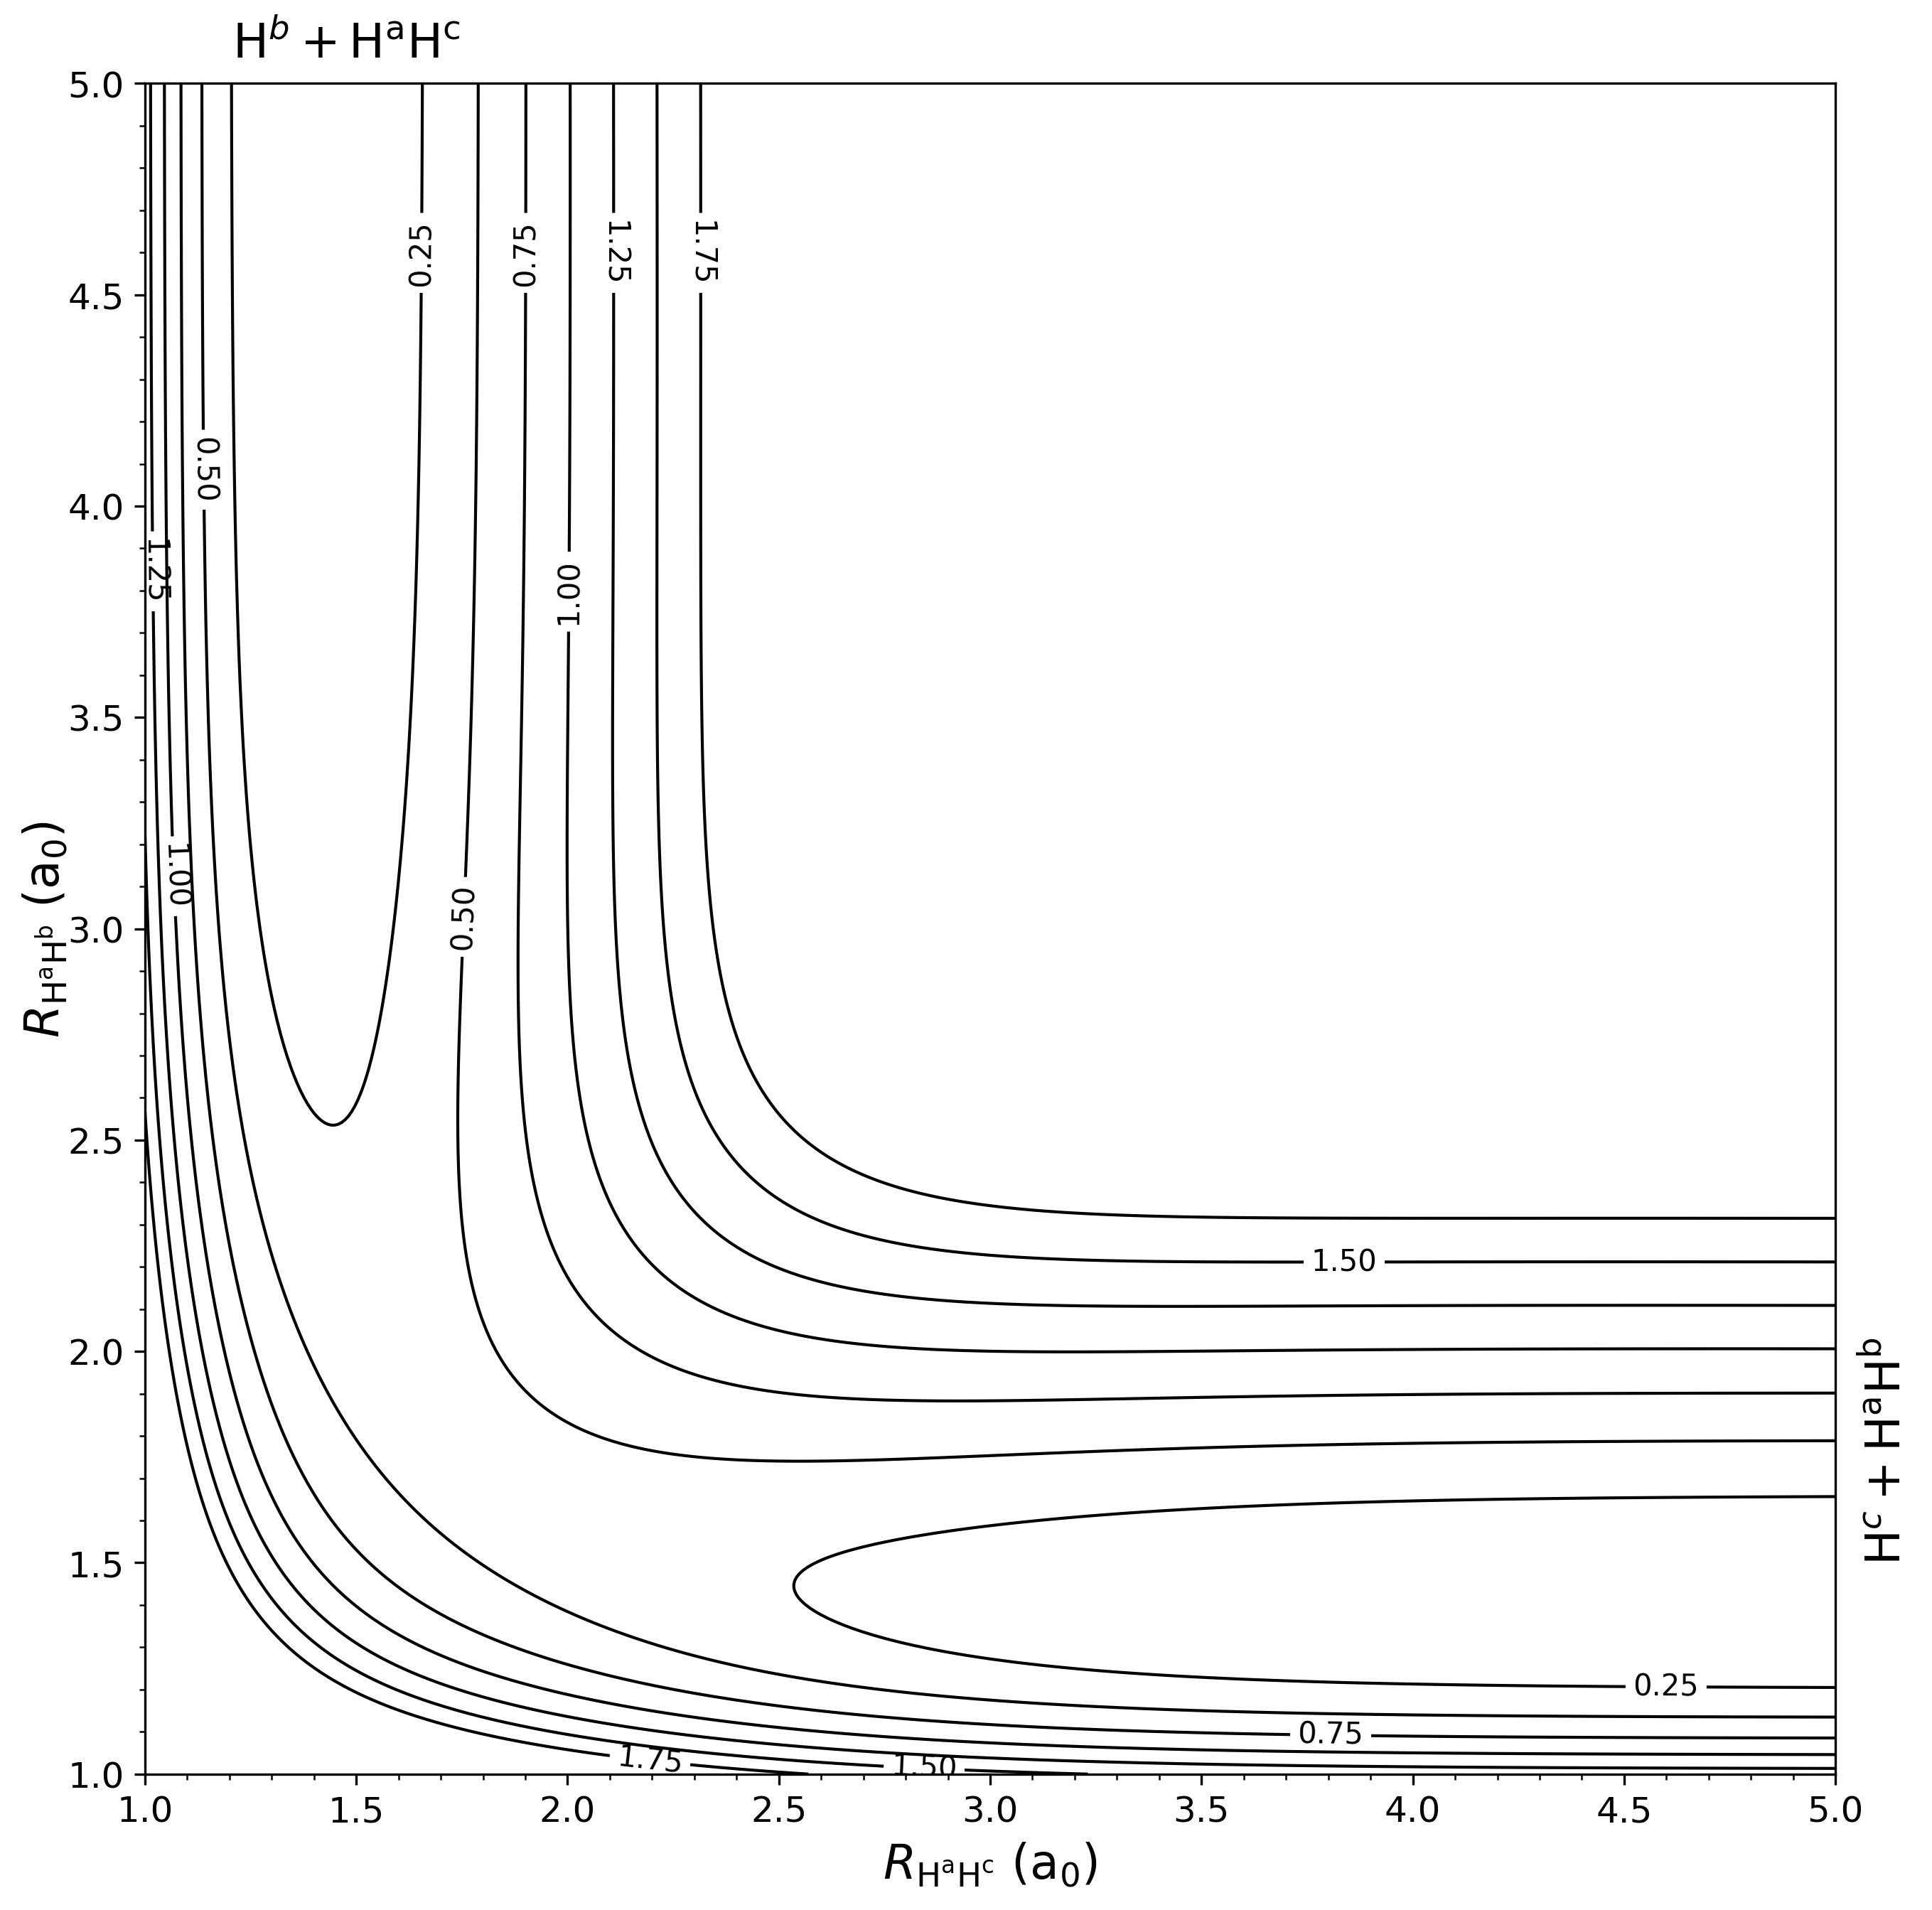

In [ ]:
def v(coord):

    r1, r2, r3 = coord
    p1 = np.exp(-r1)
    p2 = np.exp(-r2)
    p3 = np.exp(-r3)

    s1, s2, s3 = symm(p1, p2, p3)
    
    r = np.array([[s1, s2, s3]])
    r_escalado = (r - x.mean(axis=0))/x.std(axis=0)
    
    return (melhor_mlp.predict(r_escalado)* e.std() + e.mean())

def vint(params):

    r1 = params[0]
    r2 = params[1]
    theta = params[2]

    R12 = np.sqrt(r1**2 + r2**2 - 2*r1*r2*np.cos(theta*np.pi/180.0))
    R13 = r1
    R23 = r2


    pot = v((R12, R13, R23))

    return pot


cut_dim = 500
R1 = np.linspace(1.0, 5.0, cut_dim)
R2 = np.linspace(1.0, 5.0, cut_dim)
theta = 179.99

X, Y = np.meshgrid(R1,R2)
E = np.zeros(X.shape)

for i in range(cut_dim):
    for j in range(cut_dim):
        E[i, j] = vint([R1[i], R2[j], theta])*27.211386

z_lim = 2.75
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=[9,9], dpi=300,
           facecolor=None, edgecolor=None,
           linewidth=1.0, frameon=None, subplotpars=None, tight_layout=None)
ax = plt.subplot(111)

plt.xlabel('$R_\mathrm{H^aH^c}$ (a$_0$)', fontsize=16)
minorLocator   = matplotlib.ticker.MultipleLocator(0.1)
ax.xaxis.set_minor_locator(minorLocator)
plt.ylabel('$R_\mathrm{H^aH^b}$ (a$_0$)', fontsize=16, labelpad=-0.5)
ax.yaxis.set_minor_locator(minorLocator)

plt.tight_layout()

plt.figtext(0.13, 0.98, '$\mathrm{H}^b + \mathrm{H^aH^c}$', size=16)
plt.figtext(0.98, 0.20, '$\mathrm{H}^c + \mathrm{H^aH^b}$', size=16, rotation=90)
            
CS = plt.contour(X, Y, E,
                 colors='k', # negative contours will be dashed by default
                 linewidths = 1.0,
                 levels = np.arange(-0.5,int(z_lim),0.25)
                 )

plt.clabel(CS, fontsize=10, fmt='%3.2f', inline_spacing=7)
ax.set_aspect('equal')
plt.show()                                                                
                                                             